# Regression model for predicting the amount of Code Smells

In [1]:
import pandas as pd
import numpy as np
import os
import dataloader_functions.dataloader_fulldata_AmountCodeSmells as dataloader
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from joblib import dump, load

## Preparing data for prediction
The numerical columns in the data are scaled to make the variables more comparable to the model.

### Pre-selecting variables
For the models, only metrics are used. This excludes all variables that count or describe issues. Identificators like IDs or dates are also excluded. Ther are distribution variables that do count into software metrics, however they are not fit for modelling, as they are neither categorical nor numerical variables.

In [2]:
# define necessary variables for data setup
variable_list = [
    'CODE_SMELLS',
    'CLASSES',
    'FILES',
    'LINES',
    'NCLOC',
    'PACKAGE',
    'STATEMENTS',
    'FUNCTIONS',
    'COMMENT_LINES',
    'COMPLEXITY',
    'CLASS_COMPLEXITY',
    'FUNCTION_COMPLEXITY',
    'COGNITIVE_COMPLEXITY',
    'LINES_TO_COVER',
    'UNCOVERED_LINES',
    'DUPLICATED_LINES',
    'DUPLICATED_BLOCKS',
    'DUPLICATED_FILES',
    'COMMENT_LINES_DENSITY',
    'DUPLICATED_LINES_DENSITY'
]

label = 'CODE_SMELLS'

current_dir = os.getcwd()
model_save_dir = os.path.join(current_dir, '..', '..', 'Data', 'Models', 'CodeSmells')

df = dataloader.load_df(current_dir)
df = dataloader.put_label_in_front(df, label)
df = dataloader.select_variables(df, variable_list)
df = dataloader.scale_predictors(df, label)
df

,CODE_SMELLS,CLASSES,FILES,LINES,NCLOC,PACKAGE,STATEMENTS,FUNCTIONS,COMMENT_LINES,COMPLEXITY,CLASS_COMPLEXITY,FUNCTION_COMPLEXITY,COGNITIVE_COMPLEXITY,LINES_TO_COVER,UNCOVERED_LINES,DUPLICATED_LINES,DUPLICATED_BLOCKS,DUPLICATED_FILES,COMMENT_LINES_DENSITY,DUPLICATED_LINES_DENSITY
0,17012,0.707998,0.114798,0.314222,0.571297,0.342736,0.841017,0.593938,-0.346117,0.821715,1.442628,1.588837,1.352548,0.702365,0.702365,0.407604,0.610631,0.166980,-1.710559,0.262477
1,16987,0.707998,0.114798,0.310393,0.565516,0.342736,0.841017,0.593938,-0.346196,0.821715,1.442628,1.588837,1.352548,0.702365,0.702365,0.404699,0.609715,0.157664,-1.710559,0.262477
2,16987,0.707998,0.114798,0.310393,0.565516,0.342736,0.841017,0.593938,-0.346196,0.821715,1.442628,1.588837,1.352548,0.702365,0.702365,0.404699,0.609715,0.157664,-1.710559,0.262477
3,17013,0.707998,0.114798,0.314070,0.571095,0.342736,0.841017,0.593938,-0.346196,0.821715,1.442628,1.588837,1.352548,0.702365,0.702365,0.407604,0.610631,0.166980,-1.710559,0.262477
4,17013,0.707998,0.114798,0.314053,0.571070,0.342736,0.841017,0.593938,-0.346196,0.821715,1.442628,1.588837,1.352548,0.702365,0.702365,0.407604,0.610631,0.166980,-1.710559,0.262477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140743,268,-0.768491,-0.779031,-0.738544,-0.683567,-0.772243,-0.666976,-0.664161,-0.819923,-0.633137,-0.830480,-0.629689,-0.670437,-0.724777,-0.724777,-0.527839,-0.490534,-0.792615,0.402842,-0.861747
140744,269,-0.768491,-0.779031,-0.738511,-0.683435,-0.772243,-0.666874,-0.664385,-0.820042,-0.633035,-0.830480,-0.629689,-0.670230,-0.724693,-0.724693,-0.527839,-0.490534,-0.792615,0.391100,-0.861747
140745,266,-0.768491,-0.779031,-0.738908,-0.683901,-0.772243,-0.667108,-0.664459,-0.820834,-0.633240,-0.830480,-0.629689,-0.670593,-0.725016,-0.725016,-0.527839,-0.490534,-0.792615,0.391100,-0.855094
140746,266,-0.768491,-0.779031,-0.738908,-0.683901,-0.772243,-0.667108,-0.664459,-0.820834,-0.633240,-0.830480,-0.629689,-0.670593,-0.725016,-0.725016,-0.527839,-0.490534,-0.792615,0.391100,-0.855094


### Handle missing variables
The regression models used need data that doesn't contain missing values. It is to be investigated how many rows are affected
by any missing values

In [3]:
df[df.isnull().any(axis=1)]

,CODE_SMELLS,CLASSES,FILES,LINES,NCLOC,PACKAGE,STATEMENTS,FUNCTIONS,COMMENT_LINES,COMPLEXITY,CLASS_COMPLEXITY,FUNCTION_COMPLEXITY,COGNITIVE_COMPLEXITY,LINES_TO_COVER,UNCOVERED_LINES,DUPLICATED_LINES,DUPLICATED_BLOCKS,DUPLICATED_FILES,COMMENT_LINES_DENSITY,DUPLICATED_LINES_DENSITY
83594,0,NaN,-0.834141,-0.774206,-0.712578,-0.876308,NaN,NaN,-0.880272,NaN,NaN,NaN,NaN,NaN,NaN,-0.529170,-0.492364,-0.797273,-1.863193,-0.908312
83595,0,NaN,-0.834141,-0.774219,-0.712710,-0.876308,NaN,NaN,-0.879599,NaN,NaN,NaN,NaN,NaN,NaN,-0.529170,-0.492364,-0.797273,-0.935645,-0.908312
83596,0,NaN,NaN,NaN,NaN,-0.876308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.529170,-0.492364,-0.797273,NaN,NaN
103801,0,NaN,NaN,NaN,NaN,-0.876308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.529170,-0.492364,-0.797273,NaN,NaN
104417,0,NaN,NaN,NaN,NaN,-0.876308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.529170,-0.492364,-0.797273,NaN,NaN
104418,0,NaN,NaN,NaN,NaN,-0.876308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.529170,-0.492364,-0.797273,NaN,NaN
107114,0,NaN,NaN,NaN,NaN,-0.876308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.529170,-0.492364,-0.797273,NaN,NaN
107115,0,NaN,NaN,NaN,NaN,-0.876308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.529170,-0.492364,-0.797273,NaN,NaN
110583,1705,NaN,NaN,NaN,NaN,-0.831709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.501921,-0.425544,-0.755349,NaN,NaN
110584,1704,NaN,NaN,NaN,NaN,-0.839142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.501921,-0.425544,-0.755349,NaN,NaN


Only 29 rows out of 140748 are affected, so instead of filling those NAs, they just get omitted.

In [4]:
# drop the 29 rows that contain NAs
df = df.dropna()

## Splitting data into training and testing
The train-test-split for this model is 70/30. <br>
Prediction errors are tracked over each model to see how the prediction improves.

In [5]:
# train-test-split
X = df.drop(columns = "CODE_SMELLS")
y = df["CODE_SMELLS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# setup error tracker
mse_track = []
mae_track = []

## Relationship between Code Smells and selected predictors
To gain a better understanding of how the label and predictors are related to each other, scatterplots are used.

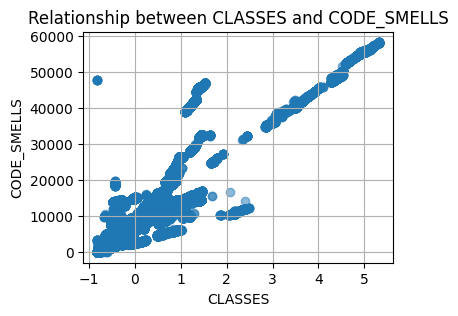

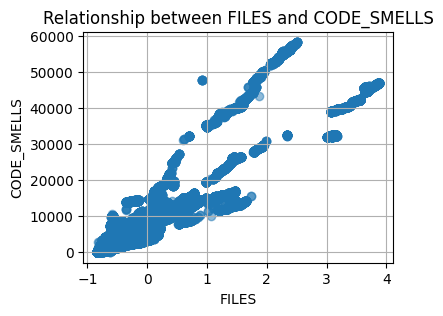

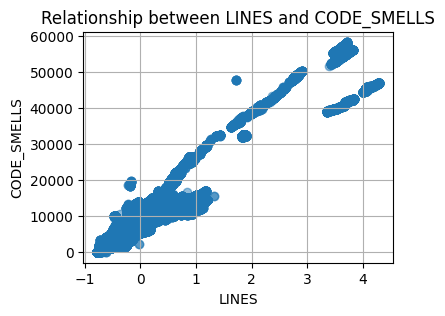

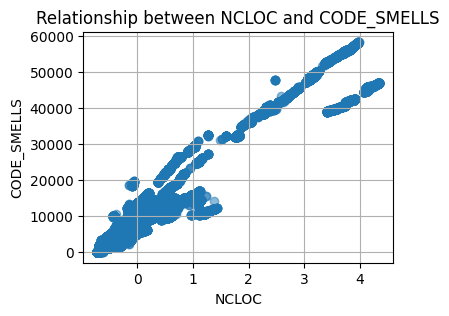

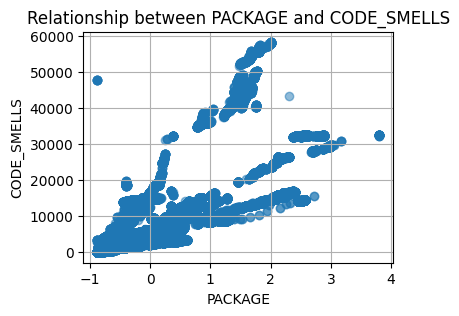

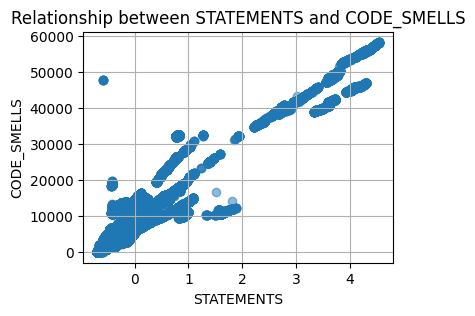

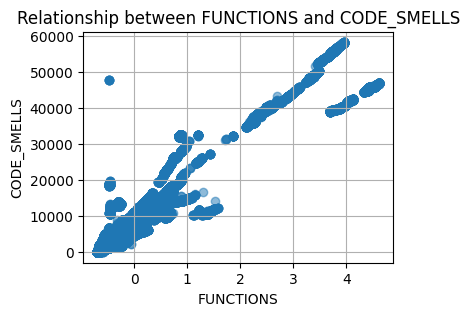

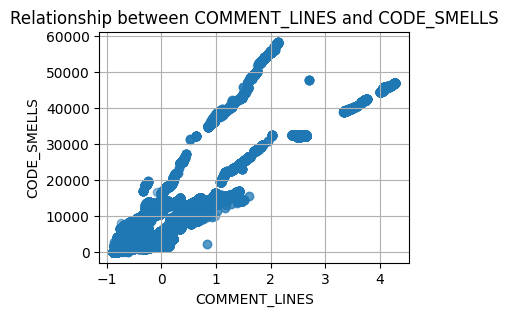

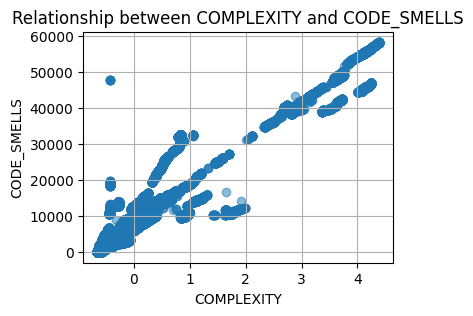

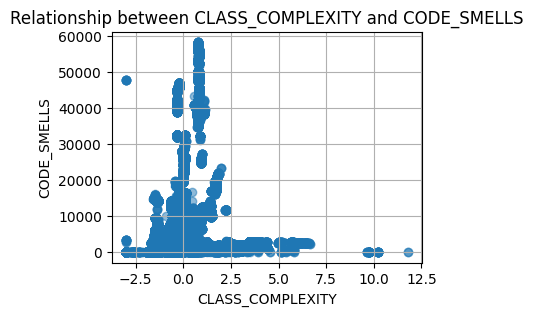

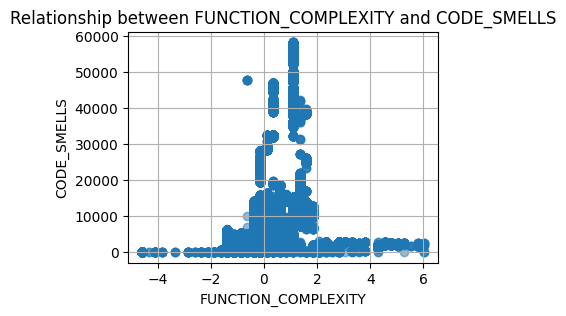

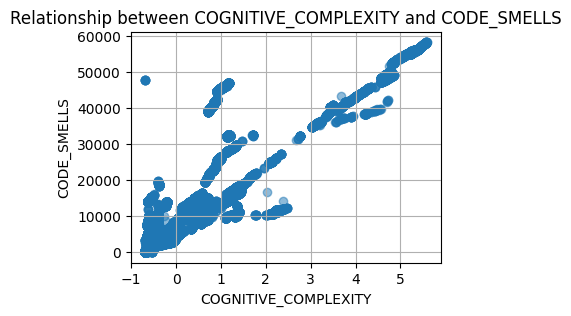

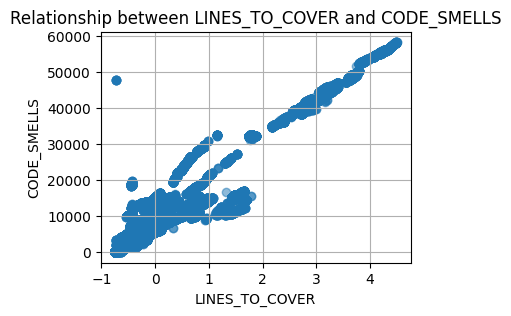

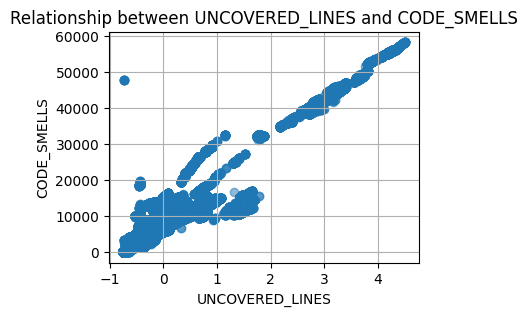

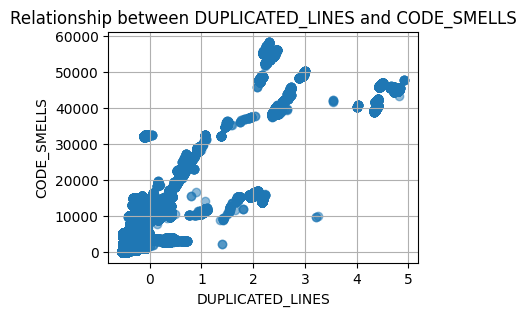

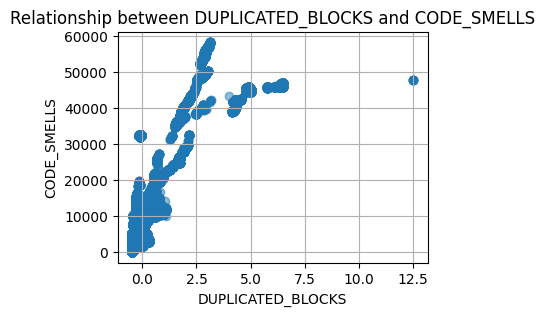

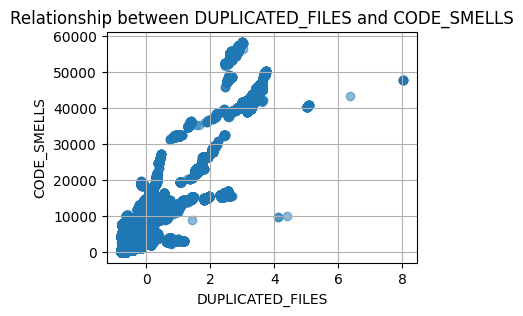

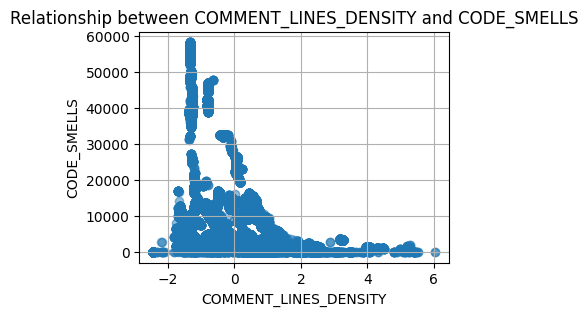

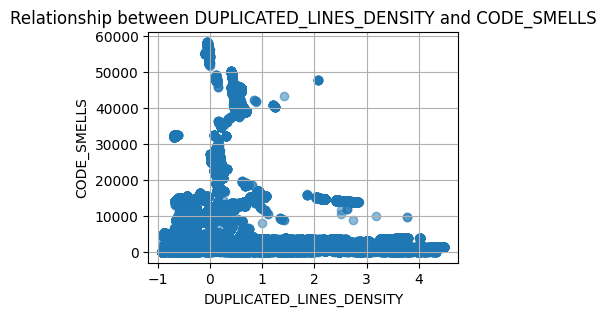

In [6]:
for i, col in enumerate(df.drop(columns = "CODE_SMELLS").columns):
    plt.figure(figsize=(4,3))
    plt.scatter(df.drop(columns = "CODE_SMELLS")[col], df["CODE_SMELLS"], alpha=0.5)
    plt.xlabel(col)
    plt.ylabel('CODE_SMELLS')
    plt.title(f'Relationship between {col} and CODE_SMELLS')
    plt.grid(True)
    plt.show()

Most of the predictors have a very much linear relation ship to code smells. Therefore, a simple linear regression model is a
promising choice.

## Multiple Linear Regression Model

In [7]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions on the test set
lr_y_pred = lr_model.predict(X_test)

# Evaluate the model
lr_mse = mean_squared_error(y_test, lr_y_pred)
lr_r2 = r2_score(y_test, lr_y_pred)
mae = mean_absolute_error(y_test, lr_y_pred)

print("\nMultiple Linear Regression Results:")
print(f"Mean Squared Error: {lr_mse}")
print(f"R-squared: {lr_r2}")
print(f"Mean Absolute Error: {mae}")

mse_track.append(lr_mse)
mae_track.append(mae)

# save model
filename_joblib = os.path.join(model_save_dir, "MLR", "MLR_all_predictors.joblib")
dump(lr_model, filename_joblib)


Multiple Linear Regression Results:
Mean Squared Error: 4177691.2869783975
R-squared: 0.9658041659483734
Mean Absolute Error: 1249.613578131741


['C:\\Users\\carol\\Dropbox\\DataScience\\Semester4\\MasterProjectSonarQube\\Scripts\\Model\\..\\..\\Data\\Models\\CodeSmells\\MLR\\MLR_all_predictors.joblib']

In [8]:
X_train_sm = sm.add_constant(X_train)
lr_model_sm = sm.OLS(y_train, X_train_sm).fit()

print(lr_model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:            CODE_SMELLS   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                 1.558e+05
Date:                Sat, 17 May 2025   Prob (F-statistic):               0.00
Time:                        16:44:33   Log-Likelihood:            -8.8947e+05
No. Observations:               98505   AIC:                         1.779e+06
Df Residuals:                   98486   BIC:                         1.779e+06
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

### Variable Selection based on significance
Given the model report, the variables "FILES" and "STATEMENTS" are not significant for the model (alpha = 0.05). They are getting removed from the model.

In [9]:
# train-test-split
X = df.drop(columns = ["CODE_SMELLS", "FILES", "STATEMENTS"])
y = df["CODE_SMELLS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train_sm = sm.add_constant(X_train)
lr_model_sm2 = sm.OLS(y_train, X_train_sm).fit()

print(lr_model_sm2.summary())

X_test_sm = sm.add_constant(X_test)
lr_y_pred_sm = lr_model_sm2.predict(X_test_sm)

lr_mse = mean_squared_error(y_test, lr_y_pred_sm)
lr_r2 = r2_score(y_test, lr_y_pred_sm)
mae = mean_absolute_error(y_test, lr_y_pred_sm)

print("-----------------------------------------------------------------")
print("\nMultiple Linear Regression Results:")
print(f"Mean Squared Error: {lr_mse}")
print(f"R-squared: {lr_r2}")
print(f"Mean Absolute Error: {mae}")

mse_track.append(lr_mse)
mae_track.append(mae)

filename_joblib = os.path.join(model_save_dir, "MLR", "MLR_sign_predictors.joblib")
dump(lr_model_sm2, filename_joblib)

                            OLS Regression Results                            
Dep. Variable:            CODE_SMELLS   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                 1.664e+05
Date:                Sat, 17 May 2025   Prob (F-statistic):               0.00
Time:                        16:44:33   Log-Likelihood:            -8.9193e+05
No. Observations:               98505   AIC:                         1.784e+06
Df Residuals:                   98488   BIC:                         1.784e+06
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

['C:\\Users\\carol\\Dropbox\\DataScience\\Semester4\\MasterProjectSonarQube\\Scripts\\Model\\..\\..\\Data\\Models\\CodeSmells\\MLR\\MLR_sign_predictors.joblib']

When letting out the two variables, the test performance gets worse. For the following models, those variables are included again.

### Looking into the multicollinearity problem
The linear regression model has a note that adresses that the model might have a multicollinearity problem. This means that there are
predictors which are highly correlated to the label and therefore introduce instability and a worse generalisability on unseen data. <br>
First, correlations are again investigated between code smells and the predictors present in the data. <br>
Afterwards, ridge regression is done to shrink the coefficients and through that make the model more stable.

### Investigating correlations between code smells and predictors

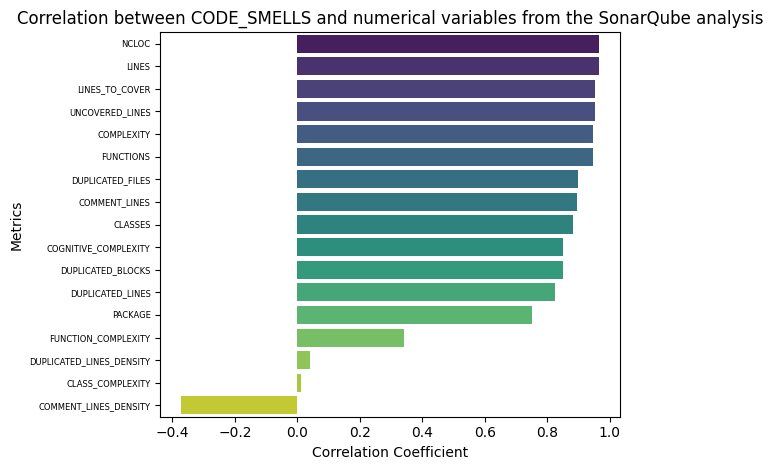

In [10]:

correlations = df.drop(columns = ["FILES", "STATEMENTS"]).corr()["CODE_SMELLS"].sort_values(ascending=False)
correlations = correlations.drop("CODE_SMELLS")

plt.figure()
sns.barplot(x=correlations.values, y=correlations.index, hue=correlations.index, palette = 'viridis')
plt.title(f'Correlation between CODE_SMELLS and numerical variables from the SonarQube analysis')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Metrics')
plt.yticks(fontsize=6)
plt.tight_layout()
plt.show()

From the plot it can be seen that almost all variables are strongly correlated to the label. However, it doesn't tell us
about how the variables are correlated to each other. The variance inflation factor is used to investigate that further.

### Investigating the Variance Inflation Factor (VIF)
The VIF measures how much predictors might be correlated to each other. A high VIF means that a predictor is strongly correlated with other predictors in the dataset.

In [11]:
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

vif_train = calculate_vif(X_train)
print("\nVIF for Training Data:")
print(vif_train)

C:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



VIF for Training Data:
                     feature         VIF
0                    CLASSES   66.694932
1                      LINES  303.416440
2                      NCLOC  362.302575
3                    PACKAGE   12.677078
4                  FUNCTIONS  855.943237
5              COMMENT_LINES   29.584607
6                 COMPLEXITY  887.922805
7           CLASS_COMPLEXITY    2.142854
8        FUNCTION_COMPLEXITY    2.710053
9       COGNITIVE_COMPLEXITY  107.589378
10            LINES_TO_COVER         inf
11           UNCOVERED_LINES         inf
12          DUPLICATED_LINES   38.675007
13         DUPLICATED_BLOCKS   27.551244
14          DUPLICATED_FILES   38.619817
15     COMMENT_LINES_DENSITY    2.371708
16  DUPLICATED_LINES_DENSITY    1.604225


For a lot of variables, the VIF is very high. This means that they are strongly correlated not only to the label but also to
other predictors. <br>
The high VIFs across multiple variables proofs, that there is a multicollinearity problem. This can be countered by using a penalizing method such as Ridge Regression (https://www.ibm.com/think/topics/multicollinearity).

### Ridge Regression
The Ridge Regression model is fit on all metrics. To find the best penalty term alpha, a range of alpha values is generated and tested for best validation performance with cross validation.

In [12]:
# train-test-split so the previously excluded variables are included again.
X = df.drop(columns = "CODE_SMELLS")
y = df["CODE_SMELLS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# create a range of alpha (lambda) values to crossvalidate
alphas = 10 ** np.arange(3, -2 - 0.1, -0.1)

# find the best alpha by using 10 fold cross validation
ridge_cv = RidgeCV(alphas=alphas, cv=10)
ridge_cv.fit(X_train, y_train)

# get best lambda value
best_alpha = ridge_cv.alpha_
print(f"\nBest Lambda (Alpha) from Cross-Validation: {best_alpha}")

# fit ridge regression model with best lambda
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_train, y_train)

# make predictions on test set for evaluation metrics
ridge_y_pred = ridge_best.predict(X_test)

# model evaluation
ridge_mse = mean_squared_error(y_test, ridge_y_pred)
ridge_r2 = r2_score(y_test, ridge_y_pred)
ridge_mae = mean_absolute_error(y_test, ridge_y_pred)

print("\nRidge Regression with Cross-Validated Lambda Results:")
print(f"Mean Squared Error: {ridge_mse}")
print(f"R-squared: {ridge_r2}")
print(f"Mean Absolute Error: {ridge_mae}")

mse_track.append(ridge_mse)
mae_track.append(ridge_mae)

filename_joblib = os.path.join(model_save_dir, "MLR", "MLR_ridge.joblib")
dump(ridge_best, filename_joblib)


Best Lambda (Alpha) from Cross-Validation: 0.15848931924611012

Ridge Regression with Cross-Validated Lambda Results:
Mean Squared Error: 4177686.6918962416
R-squared: 0.9658042035606946
Mean Absolute Error: 1249.7299064033853


['C:\\Users\\carol\\Dropbox\\DataScience\\Semester4\\MasterProjectSonarQube\\Scripts\\Model\\..\\..\\Data\\Models\\CodeSmells\\MLR\\MLR_ridge.joblib']

## Evaluation of the linear regression models

In [13]:
error_df = pd.DataFrame(
    {
        "model": ["MLR - all predictors", "MLR - significant predictors", "MLR - Ridge Regression"],
        "mse": mse_track,
        "mae": mae_track
    }
)

error_df

,model,mse,mae
0,MLR - all predictors,4.177691e+06,1249.613578
1,MLR - significant predictors,4.354662e+06,1351.855916
2,MLR - Ridge Regression,4.177687e+06,1249.729906


## Result
Out of the tested models for Linear Regression, the MLR model with all predictors and the Ridge Regression model perform best.